In [23]:
import joblib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

## 5.1 Configurações

In [24]:
# Estados do Brasil
gdf = gpd.read_file('../datas/external/brazil-states.geojson', encoding='utf-8')

# Estado da Paraíba
estado_gdf = gdf[gdf['name'] == 'Paraíba']

## 5.2 Funções

In [25]:
def gerador_de_df(estado_gdf, ano_inicial, ano_final):

    # Definir os limites da área de contorno
    contorno = estado_gdf.geometry.iloc[0]
    x_min, y_min, x_max, y_max = contorno.bounds

    # Criar uma lista para armazenar os pontos dentro do contorno
    pontos_dentro_contorno = []

    # Definir a quantidade de pontos na grade
    num_points = 200  # Aumente este número para uma grade mais fina

    # Gerar os pontos dentro da área de contorno
    for i in range(num_points):
        for j in range(num_points):
            x = x_min + i * (x_max - x_min) / (num_points - 1)
            y = y_min + j * (y_max - y_min) / (num_points - 1)
            point = Point(x, y)
            if contorno.contains(point):
                pontos_dentro_contorno.append((x, y))

    # Criando DataFrame
    latlon = []

    for i in range(len(pontos_dentro_contorno)):
        for j in range(1, 13):
            for k in range(ano_inicial, ano_final + 1):
                latlon.append({'lat': pontos_dentro_contorno[i][1],
                            'lon': pontos_dentro_contorno[i][0],
                            'ano': k,
                            'mes': j})

    return pd.DataFrame(latlon)

In [26]:
def grafico_de_chuvas(df: pd.DataFrame,
                      variavel: str,
                      unidade: str,
                      tamanho_dos_pontos: int,
                      tipo_dos_pontos: str = None):

    # Criar a figura
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotar o mapa base do estado
    estado_gdf.plot(ax=ax, color='white', edgecolor='black')

    if tipo_dos_pontos == 'quadrado':

        # Plotar os dados preditos como uma imagem
        scatter = ax.scatter(df['lon'], df['lat'], c=df[variavel], cmap='viridis', alpha=0.8, s=tamanho_dos_pontos, edgecolors='none', marker='s')

    else:

        # Plotar os dados preditos como uma imagem
        scatter = ax.scatter(df['lon'], df['lat'], c=df[variavel], cmap='viridis', alpha=0.8, s=tamanho_dos_pontos, edgecolors='none')

    # Adicionar uma barra de cores
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
    cbar.set_label(unidade)

    # Adicionar títulos e rótulos
    # plt.title('Mapa de Precipitação Mensal Anual Acumulada')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Mostrar o mapa
    plt.show()

## Mapa de Precipitação Mensal Anual Acumulada (Dados Locais)

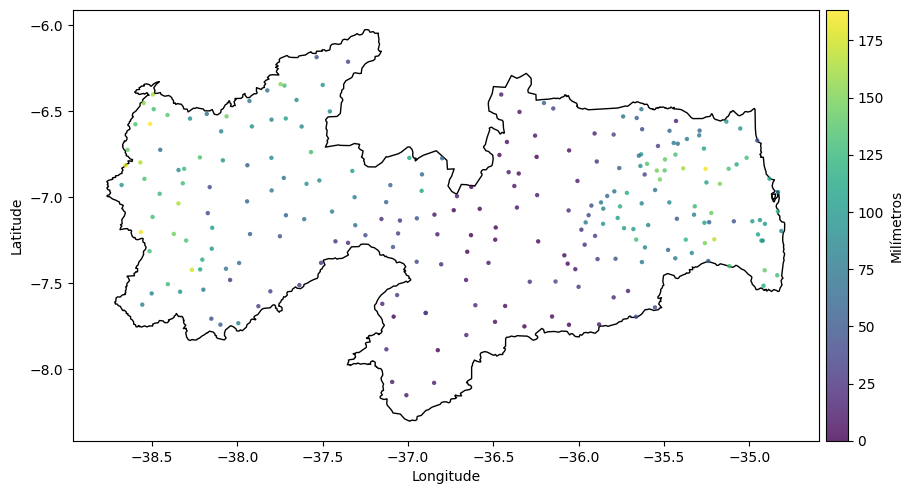

In [49]:
# Carregar os dados
df_aesa_sum = pd.read_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_sum.csv")
df_aesa_sum = df_aesa_sum[(df_aesa_sum['ano'] == 2023) & (df_aesa_sum['mes'] == 1)]

grafico_de_chuvas(df_aesa_sum, 'pr_local', 'Milímetros', 10)

## Mapa de Precipitação Mensal Anual Acumulada (Dados CMIP6)

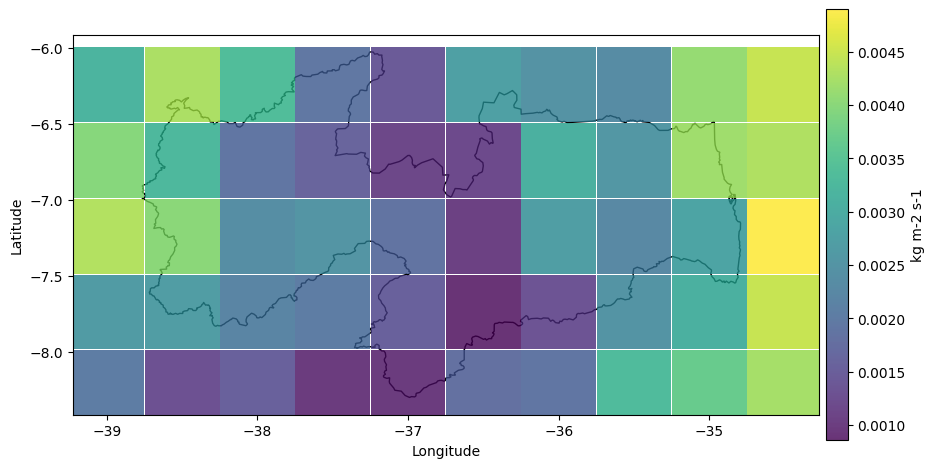

In [47]:
# Carregar os dados
df_cmip6_sum = pd.read_csv('../datas/interim/1.3.2_cmip6_database_create/pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_19940101-21001231_sum.csv')
df_cmip6_sum['lon'] = df_cmip6_sum['lon'] - 360
df_cmip6_sum = df_cmip6_sum[(df_cmip6_sum['ano'] == 2023) & (df_cmip6_sum['mes'] == 1)]

grafico_de_chuvas(df_cmip6_sum, 'pr', 'kg m-2 s-1', 2900, 'quadrado')

## Mapa de Precipitação Mensal Anual Acumulada (Dados de Redução de Escala)

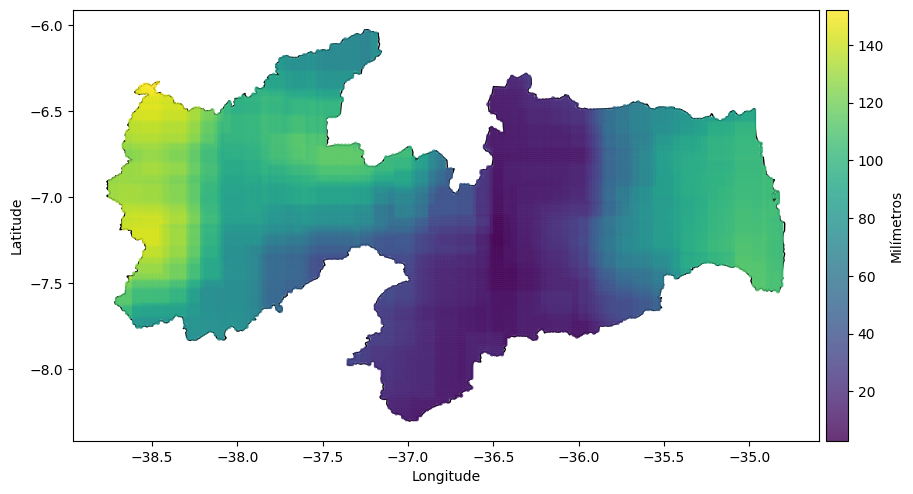

In [36]:
model = joblib.load("../models/aesa_to_cnrm_cm6_1hr_sum_downscaling_database.joblib")

df_espacializado = gerador_de_df(estado_gdf, 2023, 2023)
df_espacializado = df_espacializado[model.feature_names_in_]
df_espacializado = df_espacializado[df_espacializado['mes'] == 1]
df_espacializado['pr'] = model.predict(df_espacializado)

grafico_de_chuvas(df_espacializado, 'pr', 'Milímetros', 10)